# LeNet Lab
![LeNet Architecture](lenet.png)
Source: Yan LeCun

## Load Data

Load the MNIST data, which comes pre-loaded with TensorFlow.

You do not need to modify this section.

In [1]:
# Load pickled data
import pickle
import numpy as np

# TODO: Fill this in based on where you saved the training and testing data

training_file = "/home/andy/Desktop/udacity-p2/train.p"
validation_file= "/home/andy/Desktop/udacity-p2/valid.p"
testing_file = "/home/andy/Desktop/udacity-p2/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

The MNIST data that TensorFlow pre-loads comes as 28x28x1 images.

However, the LeNet architecture only accepts 32x32xC images, where C is the number of color channels.

In order to reformat the MNIST data into a shape that LeNet will accept, we pad the data with two rows of zeros on the top and bottom, and two columns of zeros on the left and right (28+2+2 = 32).

You do not need to modify this section.

## Visualize Data

View a sample from the dataset.

You do not need to modify this section.

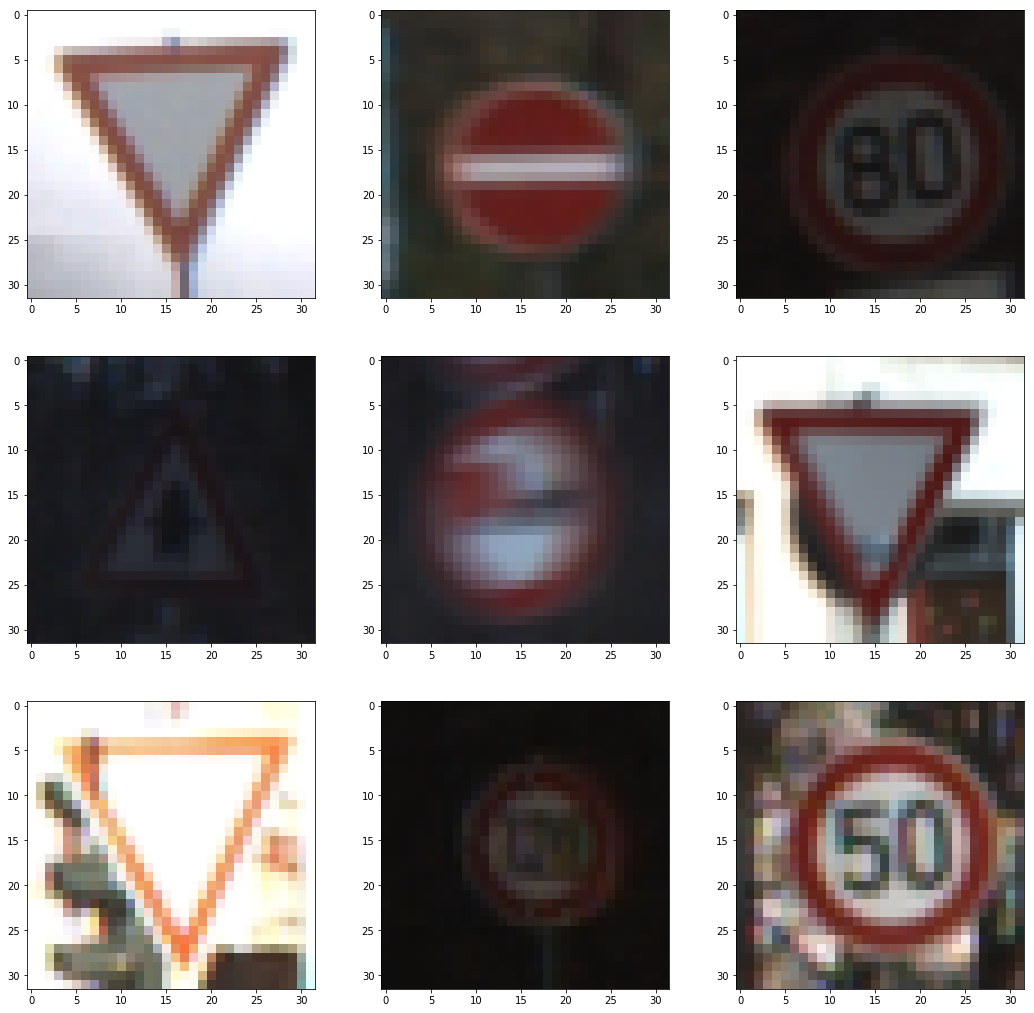

In [2]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
from random import randint
# Visualizations will be shown in the notebook.
%matplotlib inline

# select a few example images from a few classes from train\
def rand_subset(train, classes = 5, index = 9):
    #selected_classes = []
    #for i in range(0, 5):
        #selected_classes.append(randint(train["labels"].min(), train["labels"].max()))

    # grab a subset of classes
    #train_subset = {"features": train["features"] for label in selected_classes}

    # get a few random selections 
    selected_index = []
    for i in range(0, index):
        selected_index.append(randint(0, train["features"].shape[0]))
    
    # final subset 
    train_subset = train["features"][selected_index]
    
    return train_subset


train_subset = rand_subset(train)

# plot all on one figure 
plt.figure(figsize=(18, 18))
for i, image in  enumerate(train_subset):
    plt.subplot(331+i)
    plt.imshow(image)


## Preprocess Data

Shuffle the training data.

You do not need to modify this section.

In [3]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

# simple normalize approx. can make better later
def pix_norm(x):
    y = (x - 128) / 128
    return y


# "normalize" all the sets 
X_train = pix_norm(X_train)
X_validation = pix_norm(X_validation)
X_test = pix_norm(X_test)



## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

You do not need to modify this section.

In [4]:
import tensorflow as tf



# Model archetecture

The model is a combination of the class lab on LeNet, my code, and inpriration from these two sources:

source [1] https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf 


source [2] https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/

---

The archetecture is as follows: 

* Input   : 32x32x3


* Layer  1: 3x3x6 filter Convolution

* Layer  2: 2x2x6 filter Max pool

* Layer  3: 5x5x12 filter Convolution

* Layer  4: Inception-like module concatonating:
    * 1x1x12 filter convolution
    
    * 1x1x12 filter convolution -> 5x5x12 filter convolution
    
    * 3x3x12 filter Max pool -> 1x1x12 filter convolution
    
    * 1x1x12 filter convlution -> 3x3x12 filter convolution
    
    
* Layer  5: 7x7x60 filter convolution

* Layer  6: 2x2x60 filter Max pool

* Layer  7: Fully connected with dropout 240x500

* Layer  8: Fully connected with dropout 500x250

* Layer  9: Fully connected with dropout 250x125

* Layer 10: Fully connected with dropout 125x43


* Output  : Softmax layer put in loss function

---



In [5]:
## below is the model archetecture I implemented to classify traffic signs.
# it is built off the LeNet starting point given in the class material. 

from tensorflow.contrib.layers import flatten

def andret(x):    
    #=============================================================================
    # hyper params
    mu = 0
    sigma = 0.1
    
    # added hyper parameter for dropout 
    keep_prob = 0.2
    #=============================================================================

    #=============================================================================
    # conv Layer 1
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    #=============================================================================

    #============================================================================
    # pooling 1
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #=============================================================================

    #=============================================================================
    # conv Layer 2
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 12), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(12))
    conv2   = tf.nn.conv2d(conv1_pool, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    #=============================================================================
    
    #=============================================================================
    # layer 3: try inception-like layer 
    incept1_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 12, 12), mean = mu, stddev = sigma))
    incept1_b = tf.Variable(tf.zeros(12))
    incept1   = tf.nn.conv2d(conv2, incept1_W, strides=[1, 1, 1, 1], padding='SAME') + incept1_b
    incept1 = tf.nn.relu(incept1)
    
    incept2_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 12, 12), mean = mu, stddev = sigma))
    incept2_b = tf.Variable(tf.zeros(12))
    incept2   = tf.nn.conv2d(conv2, incept2_W, strides=[1, 1, 1, 1], padding='SAME') + incept2_b
    incept2 = tf.nn.relu(incept2)
    
    incept3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 12, 12), mean = mu, stddev = sigma))
    incept3_b = tf.Variable(tf.zeros(12))
    incept3   = tf.nn.conv2d(incept2, incept3_W, strides=[1, 1, 1, 1], padding='SAME') + incept3_b
    incept3 = tf.nn.relu(incept3)
    
    incept4 = tf.nn.max_pool(conv2, ksize=[1, 3, 3, 1], strides=[1, 1, 1, 1], padding='SAME')

    incept5_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 12, 12), mean = mu, stddev = sigma))
    incept5_b = tf.Variable(tf.zeros(12))
    incept5   = tf.nn.conv2d(incept4, incept5_W, strides=[1, 1, 1, 1], padding='SAME') + incept5_b
    incept5 = tf.nn.relu(incept5)
    
    incept6_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 12, 12), mean = mu, stddev = sigma))
    incept6_b = tf.Variable(tf.zeros(12))
    incept6   = tf.nn.conv2d(conv2, incept6_W, strides=[1, 1, 1, 1], padding='SAME') + incept6_b
    incept6 = tf.nn.relu(incept6)
    
    incept7_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 12, 12), mean = mu, stddev = sigma))
    incept7_b = tf.Variable(tf.zeros(12))
    incept7   = tf.nn.conv2d(incept6, incept7_W, strides=[1, 1, 1, 1], padding='SAME') + incept7_b
    incept7 = tf.nn.relu(incept7)
    
    concat_layer = tf.concat(3,[incept1, incept3, incept5, incept7])
    concat_layer = tf.nn.relu(concat_layer)
    #=============================================================================
    
    #=============================================================================
    # layer 4: conv 2d
    conv3_W = tf.Variable(tf.truncated_normal(shape=(7, 7, 48, 60), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(60))
    conv3   = tf.nn.conv2d(concat_layer, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    conv3 = tf.nn.relu(conv3)
    #=============================================================================

    #============================================================================
    # pooling 2
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #=============================================================================
      
    #=============================================================================
    # flatten out for fc layer 
    fc0   = flatten(conv3_pool)
    #=============================================================================
    
    #=============================================================================
    # fully connected with dropout
    # layer 5: fully connected with dropout, relu
    fc1_W = tf.Variable(tf.truncated_normal(shape=(240, 500), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(500))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 6: Fully Connected with dropout, relu
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(500, 250), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(250))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob)
    
    # Layer 7: Fully Connected with dropout, relu
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(250, 125), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(125))
    fc3    = tf.matmul(fc2, fc3_W) + fc3_b
    fc3    = tf.nn.relu(fc3)
    fc3    = tf.nn.dropout(fc3, keep_prob)

    # Layer 8: Fully Connected relu
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(125, 43), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(43))
    fc3    = tf.nn.dropout(fc3, keep_prob)
    logits = tf.matmul(fc3, fc4_W) + fc4_b
    #=============================================================================

    # return logits before softmax
    return logits

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.

You do not need to modify this section.

In [6]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

You do not need to modify this section.

In [7]:
# knocked rate down to stabalize model
rate = 0.0001  

logits = andret(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate, )
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [8]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [ ]:
# changed the print out setting for easy copy / paste graph of train / valid history

# traing hyper params
# "lots" of epochs
EPOCHS = 1000

# small batch size seems to run faster
BATCH_SIZE = 128

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    print("epoch,train_acc,valid_acc")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
           
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_validation, y_validation)
        #print("EPOCH,".)
        print("{}".format(i+1) + ",{:.3f}".format(training_accuracy) + ",{:.3f}".format(validation_accuracy)) 
        
    saver.save(sess, './andret')
    print()
    print("Model saved")

Training...

epoch,train_acc,valid_acc
1,0.046,0.041
2,0.052,0.048
3,0.052,0.052
4,0.052,0.048
5,0.051,0.049


## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [ ]:
# look at the test data. 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))